### Optimum Al-Sat Sinyali Oluşturma

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import yfinance as yf
import plotly.graph_objects as go

from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

#### Import Data

In [2]:
apple_df = yf.download('AAPL', start = '2017-01-01', end = '2020-11-14', progress = False)

apple_df_index = pd.to_datetime(apple_df.index)

apple_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.952711,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.922543,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.059456,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.361120,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.611734,134247600


In [3]:
apple_df.shape

(975, 6)

#### Indicator Combination

**1. Simple Moving Average (SMA):**

In [4]:
df = apple_df[["Close", "Volume"]]

df.head()

,Close,Volume
Date,,
2017-01-03,29.037500,115127600
2017-01-04,29.004999,84472400
2017-01-05,29.152500,88774400
2017-01-06,29.477501,127007600
2017-01-09,29.747499,134247600


In [5]:
def indicator_comb_MA(data, opt = 50):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    # Moving Average
    rolling_app5 = data["Close"].rolling(window = 5).mean()
    rolling_app14 = data["Close"].rolling(window = 14).mean()
    rolling_app21 = data["Close"].rolling(window = 21).mean()
    
    MAs = pd.concat([data["Close"], rolling_app5, rolling_app14, rolling_app21], axis = 1)
    MAs.columns = ['Close', 'Short', 'Mid', 'Long']
    
    up = MAs[(np.array(MAs["Short"] - MAs["Mid"]) > 0) & (np.array(MAs["Short"] - MAs["Long"]) > 0)]
    down = MAs[(np.array(MAs["Short"] - MAs["Mid"]) < 0) & (np.array(MAs["Short"] - MAs["Long"]) < 0)]
    
    ups = np.percentile(np.array(up["Short"] - up["Mid"]), opt)
    downs = np.percentile(np.array(down["Short"] - down["Long"]), opt)
    
    for i in range(0, len(MAs)):
        if (MAs["Short"][i] > MAs["Mid"][i] + ups) & (MAs["Short"][i] > MAs["Long"][i] + ups):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(MAs["Close"][i])
                buy_sell.append(MAs["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
        elif (MAs["Short"][i] < MAs["Mid"][i] + downs) & (MAs["Short"][i] < MAs["Long"][i] + downs):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(MAs["Close"][i])
                buy_sell.append(-MAs["Close"][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            
        operations = np.array(buy_sell)
        operations = operations[~np.isnan(operations)]
        
        neg = 0
        pos = 0
        
        for i in range(len(operations)):
            if operations[i] < 0:
                neg = i
                break
        for i in range(1, len(operations)):
            if operations[-i] > 0:
                pos = i-1
                break
                
        operations = operations[neg:-pos]
        PL = np.sum(operations)
        
    return (buy_signal, sell_signal, PL)    

In [6]:
opt = []

percentile = np.arange(10, 91, 5)

for i, j in enumerate(percentile):
    opt.append((percentile[i], indicator_comb_MA(df, j)[2]))
    
opt = pd.DataFrame(opt)

opt.columns = ["Percentile", "Performance"]

opt = opt.sort_values(by = "Performance", ascending = False)

opt.head()

,Percentile,Performance
16,90,59.82
9,55,0.00
15,85,0.00
14,80,0.00
13,75,0.00


In [7]:
RES = pd.DataFrame()

RES["Close"] = apple_df["Close"]

RES["BUY_MA"] = indicator_comb_MA(df, opt["Percentile"].values[0])[0]

RES["SELL_MA"] =  indicator_comb_MA(df, opt["Percentile"].values[0])[1]

res_MA = indicator_comb_MA(df, opt["Percentile"].values[0])[2]

res_MA

59.81999969482422

**2. Bollinger Bandları:**

In [8]:
def indicator_comb_BB(data):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    # Bollinger Bands
    BBs = pd.DataFrame()
    BBs["Close"] = data["Close"]
    BBs["SMA"]   = BBs["Close"].rolling(window = 20).mean()
    BBs["STD"]   = BBs["Close"].rolling(window = 20).std()
    BBs["Upper"] = BBs["SMA"] + BBs["STD"] * 2
    BBs["Lower"] = BBs["SMA"] - BBs["STD"] * 2
    
    for i in range(0, len(BBs)):
        if (BBs["Close"][i] > BBs["Upper"][i]):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(BBs["Close"][i])
                buy_sell.append(BBs["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
                
        elif (BBs["Close"][i] < BBs["Lower"][i]):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(BBs["Close"][i])
                buy_sell.append(-BBs["Close"][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            
        operations = np.array(buy_sell)
        operations = operations[~ np.isnan(operations)]
        
        neg = 0
        pos = 0
        
        for i in range(len(operations)):
            if operations[i] < 0:
                neg = i
                break
        for i in range(1, len(operations)):
            if operations[-i] > 0:
                pos = i-1
                break
                
        operations = operations[neg:-pos]
        PL = np.sum(operations)
        
    return (buy_signal, sell_signal, PL)

In [9]:
RES["BUY_BB"] = indicator_comb_BB(df)[0]

RES["SELL_BB"] = indicator_comb_BB(df)[1]

res_BB = indicator_comb_BB(df)[2]

res_BB

10.502498626708984

**3. MACD Indikatörü:**

In [10]:
def indicator_comb_MD(data, opt = 50):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    # MACD Indikatörü
    MDs = pd.DataFrame()
    MDs["Close"] = data["Close"]
    MDs["Short"] = MDs["Close"].ewm(span = 12, adjust = False).mean()
    MDs["Long"] = MDs["Close"].ewm(span = 26, adjust = False).mean()
    MDs["MACD"] = MDs["Short"] - MDs["Long"]
    MDs["Signal"] = MDs["MACD"].ewm(span = 9, adjust = False).mean()
    
    up = MDs[np.array(MDs["MACD"] - MDs["Signal"]) > 0]
    down = MDs[np.array(MDs["MACD"] - MDs["Signal"]) < 0]
    
    ups = np.percentile(np.array(up["MACD"] - up["Signal"]), opt)
    downs = np.percentile(np.array(down["MACD"] - down["Signal"]), opt)
    
    for i in range(0, len(MDs)):
        if (MDs["MACD"][i] > MDs["Signal"][i] + ups):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(MDs["Close"][i])
                buy_sell.append(MDs["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
        elif (MDs["MACD"][i] < MDs["Signal"][i] + downs):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(MDs["Close"][i])
                buy_sell.append(-MDs["Close"][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            
        operations = np.array(buy_sell)
        operations = operations[~np.isnan(operations)]
        
        neg = 0
        pos = 0
        
        for i in range(len(operations)):
            if operations[i] < 0:
                neg = i
                break
        for i in range(1, len(operations)):
            if operations[-i] > 0:
                pos = i-1
                break
                
        operations = operations[neg:-pos]
        PL = np.sum(operations)
        
    return (buy_signal, sell_signal, PL)         

In [11]:
opt = []

percentile = np.arange(10, 91, 5)

for i, j in enumerate(percentile):
    opt.append((percentile[i], indicator_comb_MD(df, j)[2]))
    
opt = pd.DataFrame(opt)

opt.columns = ["Percentile", "Performance"]

opt = opt.sort_values(by = "Performance", ascending = False)

opt.head()

,Percentile,Performance
0,10,0.0
9,55,0.0
15,85,0.0
14,80,0.0
13,75,0.0


In [12]:
RES["BUY_MD"] = indicator_comb_MD(df, opt["Percentile"].values[0])[0]

RES["SELL_MD"] = indicator_comb_MD(df, opt["Percentile"].values[0])[1]

res_MD = indicator_comb_MD(df, opt["Percentile"].values[0])[2]

res_MD

0.0

**4. RSI Indikatörü:**

In [13]:
def indicator_comb_RSI(data, opt_low = 30, opt_high = 70):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    # RSI
    RSs = pd.DataFrame()

    RSs["Close"] = data["Close"]
    RSs["Diff"] = RSs["Close"].diff(1)

    RSs["Gain"] = RSs["Diff"].mask(RSs["Diff"] < 0,0)
    RSs["Loss"] = RSs["Diff"].mask(RSs["Diff"] > 0,0)
    
    RSs["Avg_Gain"] = RSs["Gain"].rolling(window = 14).mean()
    RSs["Avg_Loss"] = RSs["Loss"].rolling(window = 14).mean()
    
    rs = abs(RSs["Avg_Gain"] / RSs["Avg_Loss"])
    RSs["rsi"] = 100 - (100 / (1 + rs))
    
    for i in range(0, len(RSs)):
        if (RSs["rsi"][i] > opt_high):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(RSs["Close"][i])
                buy_sell.append(RSs["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
        elif (RSs["rsi"][i] < opt_low):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(RSs["Close"][i])
                buy_sell.append(-RSs["Close"][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            
        operations = np.array(buy_sell)
        operations = operations[~np.isnan(operations)]
            
        neg = 0
        pos = 0
            
        for i in range(len(operations)):
            if operations[i] < 0:
                neg = i
                break
                    
        for i in range(1, len(operations)):
            if operations[-i] > 0:
                pos = i-1
                break
                    
        operations = operations[neg:-pos]
        PL = np.sum(operations)
            
    return (buy_signal, sell_signal, PL)

In [14]:
opt = []

percentile = np.arange(0, 100, 1)

for i, j in enumerate(percentile):
    if j < 50:
        opt.append((percentile[i], percentile[-(i+1)], indicator_comb_RSI(df, opt_low = percentile[i], opt_high = percentile[-(i+1)])[2]))
        
opt = pd.DataFrame(opt)

opt.columns = ["Low_Value", "High_Value", "Performance"]

opt = opt.sort_values(by = "Performance", ascending = False)

opt.head()

,Low_Value,High_Value,Performance
25,25,74,21.005005
26,26,73,19.850002
30,30,69,15.062504
27,27,72,12.977501
34,34,65,12.152504


In [15]:
RES["BUY_RS"] = indicator_comb_RSI(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[0]

RES["SELL_RS"] = indicator_comb_RSI(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[1]

res_RS = indicator_comb_RSI(df, opt_low = opt["Low_Value"].values[0], opt_high = opt["High_Value"].values[0])[2]    
                                    
res_RS                                   

21.0050048828125

**5. VWMA Indikatörü:**

In [16]:
def indicator_comb_VW(data):
    buy_sell = []
    buy_signal = []
    sell_signal = []
    flag = 42
    
    VWs = pd.DataFrame()
    VWs["Close"] = data["Close"]
    VWs["Volume"] = data["Volume"]
    
    VWs["CxV"] = VWs["Close"] * VWs["Volume"]
    VWs["VW14"] = VWs["CxV"].rolling(window = 14).sum() / VWs["Volume"].rolling(window = 14).sum()
    VWs["VW21"] = VWs["CxV"].rolling(window = 21).sum() / VWs["Volume"].rolling(window = 21).sum()
    VWs["VW50"] = VWs["CxV"].rolling(window = 50).sum() / VWs["Volume"].rolling(window = 50).sum()
    
    for i in range(0, len(VWs)):
        if (VWs["VW14"][i] > VWs["VW21"][i]) & (VWs["VW14"][i] > VWs["VW50"][i]):
            buy_signal.append(np.nan)
            if flag != 1:
                sell_signal.append(VWs["Close"][i])
                buy_sell.append(VWs["Close"][i])
                flag = 1
            else:
                sell_signal.append(np.nan)
        elif (VWs["VW14"][i] < VWs["VW21"][i]) & (VWs["VW14"][i] < VWs["VW50"][i]):
            sell_signal.append(np.nan)
            if flag != 0:
                buy_signal.append(VWs["Close"][i])
                buy_sell.append(-VWs["Close"][i])
                flag = 0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)
            
    operations = np.array(buy_sell)
    operations = operations[~ np.isnan(operations)]
    
    neg = 0
    pos = 0
    
    for i in range(len(operations)):
        if operations[i] < 0:
            neg = i
            break
    for i in range(1, len(operations)):
        if operations[-i] > 0:
            pos = i-1
            break
                
    operations = operations[neg:-pos]
    PL = np.sum(operations)
        
    return (buy_signal, sell_signal, PL)

In [17]:
RES["BUY_VW"] = indicator_comb_VW(df)[0]

RES["SELL_VW"] = indicator_comb_VW(df)[1]

res_VW = indicator_comb_VW(df)[2]

res_VW

20.74500274658203

#### Unique Results

Al/Sat işlemlerinde indikatörlerin tekil olarak karlarını ölçümlemek istersek:

In [18]:
result = {'Moving Average'                 : res_MA,
          'Bollinger Bounds'               : res_BB,
          'MACD'                           : res_MD,
          'RSI'                            : res_RS,
          'Volume Weighted Moving Average' : res_VW}

result

{'Moving Average': 59.81999969482422,
 'Bollinger Bounds': 10.502498626708984,
 'MACD': 0.0,
 'RSI': 21.0050048828125,
 'Volume Weighted Moving Average': 20.74500274658203}

In [19]:
RES.head()

,Close,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VW,SELL_VW
Date,,,,,,,,,,,
2017-01-03,29.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,29.004999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,29.152500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,29.477501,NaN,NaN,NaN,NaN,NaN,29.477501,NaN,NaN,NaN,NaN
2017-01-09,29.747499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
indics = RES.drop("Close", axis = 1).dropna(thresh = 1, axis = 0)

indics.head()

,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VW,SELL_VW
Date,,,,,,,,,,
2017-01-06,NaN,NaN,NaN,NaN,NaN,29.477501,NaN,NaN,NaN,NaN
2017-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9925,NaN,NaN
2017-02-01,NaN,NaN,NaN,32.1875,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.115002
2017-06-09,NaN,NaN,37.244999,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Combination Operations

Al/Sat işlemlerinde belirli bir metedolojiye bağlı kalarak indikatörlerin ortak etkilerini araştırmak istersek:

In [21]:
indics.reset_index(inplace = True) # Date'i içeriye değişken olarak aktarıyoruz.

indics.head()

,Date,BUY_MA,SELL_MA,BUY_BB,SELL_BB,BUY_MD,SELL_MD,BUY_RS,SELL_RS,BUY_VW,SELL_VW
0,2017-01-06,NaN,NaN,NaN,NaN,NaN,29.477501,NaN,NaN,NaN,NaN
1,2017-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9925,NaN,NaN
2,2017-02-01,NaN,NaN,NaN,32.1875,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.115002
4,2017-06-09,NaN,NaN,37.244999,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
indics = pd.melt(indics, id_vars = ['Date'], var_name = 'Metrics', value_name = 'Values').dropna(axis = 0).sort_values(["Date", "Values"])

indics[["Operation", "Indicator"]] = indics["Metrics"].str.split("_", 1, expand = True)

indics.head(20)

,Date,Metrics,Values,Operation,Indicator
360,2017-01-06,SELL_MD,29.477501,SELL,MD
505,2017-01-24,SELL_RS,29.992500,SELL,RS
218,2017-02-01,SELL_BB,32.187500,SELL,BB
651,2017-03-15,SELL_VW,35.115002,SELL,VW
148,2017-06-09,BUY_BB,37.244999,BUY,BB
5,2017-06-12,BUY_MA,36.355000,BUY,MA
438,2017-06-16,BUY_RS,35.567501,BUY,RS
583,2017-06-19,BUY_VW,36.584999,BUY,VW
224,2017-07-13,SELL_BB,36.942501,SELL,BB
513,2017-07-20,SELL_RS,37.584999,SELL,RS


In [23]:
indics.shape

(80, 5)

In [24]:
app = []

combin = []

flag = 42

for k, v in indics.groupby((indics["Operation"].shift() != indics["Operation"]).cumsum()):
    app.append(v)
    
for i in range(0, len(app)):
    if (app[i]["Operation"].values[0] == "SELL"):
        if flag != 1:
            combin.append(app[i][app[i].index == app[i]['Values'].idxmax()])
            flag = 1
        else:
            combin.append(np.nan)
    if (app[i]["Operation"].values[0] == "BUY"):
        if flag != 42:
            combin.append(app[i][app[i].index == app[i]['Values'].idxmin()])
            flag = 0
        else:
            combin.append(np.nan)      

In [25]:
combin

[          Date  Metrics     Values Operation Indicator
 651 2017-03-15  SELL_VW  35.115002      SELL        VW,
           Date Metrics     Values Operation Indicator
 438 2017-06-16  BUY_RS  35.567501       BUY        RS,
           Date  Metrics     Values Operation Indicator
 658 2017-07-26  SELL_VW  38.365002      SELL        VW,
           Date Metrics  Values Operation Indicator
 589 2017-09-26  BUY_VW  38.285       BUY        VW,
           Date  Metrics     Values Operation Indicator
 664 2017-10-27  SELL_VW  40.762501      SELL        VW,
           Date Metrics  Values Operation Indicator
 450 2018-02-02  BUY_RS  40.125       BUY        RS,
           Date  Metrics   Values Operation Indicator
 523 2018-02-26  SELL_RS  44.7425      SELL        RS,
           Date Metrics     Values Operation Indicator
 597 2018-04-09  BUY_VW  42.512501       BUY        VW,
           Date  Metrics     Values Operation Indicator
 670 2018-04-17  SELL_VW  44.560001      SELL        VW,
       

In [26]:
len(combin) # toplam yapılan optimum al-sat işlemi sayısı

27

In [27]:
combinations = combin[1]

for i in range(0, len(combin) - 1):
    combinations = pd.concat([combinations, combin[i+1]])

combinations

,Date,Metrics,Values,Operation,Indicator
438,2017-06-16,BUY_RS,35.567501,BUY,RS
438,2017-06-16,BUY_RS,35.567501,BUY,RS
658,2017-07-26,SELL_VW,38.365002,SELL,VW
589,2017-09-26,BUY_VW,38.285000,BUY,VW
664,2017-10-27,SELL_VW,40.762501,SELL,VW
450,2018-02-02,BUY_RS,40.125000,BUY,RS
523,2018-02-26,SELL_RS,44.742500,SELL,RS
597,2018-04-09,BUY_VW,42.512501,BUY,VW
670,2018-04-17,SELL_VW,44.560001,SELL,VW
599,2018-04-27,BUY_VW,40.580002,BUY,VW


In [28]:
combinations["Step"] = np.arange(0, len(combinations), 1)

combinations = combinations.loc[combinations["Step"] != 0, :]

combinations.head()

,Date,Metrics,Values,Operation,Indicator,Step
438,2017-06-16,BUY_RS,35.567501,BUY,RS,1
658,2017-07-26,SELL_VW,38.365002,SELL,VW,2
589,2017-09-26,BUY_VW,38.285000,BUY,VW,3
664,2017-10-27,SELL_VW,40.762501,SELL,VW,4
450,2018-02-02,BUY_RS,40.125000,BUY,RS,5


In [29]:
combinations.tail()

,Date,Metrics,Values,Operation,Indicator,Step
133,2020-08-04,SELL_MA,109.665001,SELL,MA,22
640,2020-09-24,BUY_VW,108.220001,BUY,VW,23
138,2020-10-13,SELL_MA,121.099998,SELL,MA,24
214,2020-10-30,BUY_BB,108.860001,BUY,BB,25
431,2020-11-06,SELL_MD,118.690002,SELL,MD,26


In [30]:
neg = 0
pos = 0

for i in range(1, len(combinations)):
    if (combinations["Operation"].values[i] == "SELL"):
        neg = i-1
        break

for i in range(1, len(combinations)):
    if (combinations["Operation"].values[-(i)] == "BUY"):
        pos = i
        break
        
operations = combinations[neg:-pos]

operations

,Date,Metrics,Values,Operation,Indicator,Step
438,2017-06-16,BUY_RS,35.567501,BUY,RS,1
658,2017-07-26,SELL_VW,38.365002,SELL,VW,2
589,2017-09-26,BUY_VW,38.285000,BUY,VW,3
664,2017-10-27,SELL_VW,40.762501,SELL,VW,4
450,2018-02-02,BUY_RS,40.125000,BUY,RS,5
523,2018-02-26,SELL_RS,44.742500,SELL,RS,6
597,2018-04-09,BUY_VW,42.512501,BUY,VW,7
670,2018-04-17,SELL_VW,44.560001,SELL,VW,8
599,2018-04-27,BUY_VW,40.580002,BUY,VW,9
674,2018-05-10,SELL_VW,47.509998,SELL,VW,10


In [31]:
desicions_buy = []
desicions_sell = []

for i in range(0, len(operations)):
    if (operations["Step"].values[i] % 2 == 0):
        desicions_sell.append(operations[["Date", "Metrics", "Values"]].iloc[i, :])
    else:
        desicions_buy.append(operations[["Date", "Metrics", "Values"]].iloc[i, :])

desicions_buy = pd.DataFrame(desicions_buy)

desicions_sell = pd.DataFrame(desicions_sell)

In [32]:
desicions_buy

,Date,Metrics,Values
438,2017-06-16,BUY_RS,35.567501
589,2017-09-26,BUY_VW,38.285000
450,2018-02-02,BUY_RS,40.125000
597,2018-04-09,BUY_VW,42.512501
599,2018-04-27,BUY_VW,40.580002
172,2018-06-25,BUY_BB,45.542500
324,2018-11-23,BUY_MD,43.072498
185,2019-05-13,BUY_BB,46.430000
192,2019-08-05,BUY_BB,48.334999
484,2020-02-27,BUY_RS,68.379997


In [33]:
desicions_buy.shape # optimum al sinyallerinin sayısı: 12

(12, 3)

In [34]:
desicions_sell

,Date,Metrics,Values
658,2017-07-26,SELL_VW,38.365002
664,2017-10-27,SELL_VW,40.762501
523,2018-02-26,SELL_RS,44.742500
670,2018-04-17,SELL_VW,44.560001
674,2018-05-10,SELL_VW,47.509998
248,2018-08-01,SELL_BB,50.375000
397,2018-12-03,SELL_MD,46.205002
263,2019-07-31,SELL_BB,53.259998
122,2020-01-14,SELL_MA,78.169998
561,2020-05-11,SELL_RS,78.752502


In [35]:
desicions_sell.shape # optimum sat sinyallerinin sayısı:12

(12, 3)

In [36]:
desicions_sell["Values"].values.sum() - desicions_buy["Values"].values.sum()

103.80250549316406

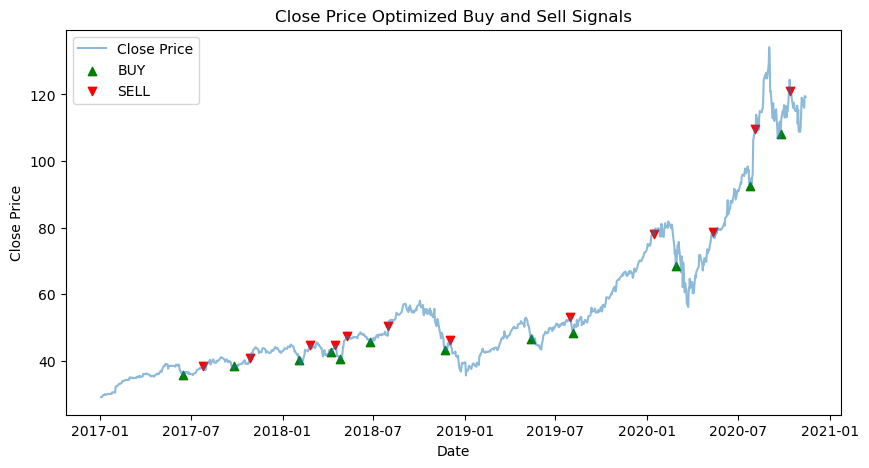

In [37]:
plt.figure(figsize = (10, 5))

plt.plot(df.index, df["Close"], label = "Close Price", alpha = 0.5)

plt.scatter(desicions_buy["Date"], desicions_buy["Values"], color = "green", label = "BUY", marker = '^', alpha = 1)
plt.scatter(desicions_sell["Date"], desicions_sell["Values"], color = "red", label = "SELL", marker = 'v', alpha = 1)

plt.title("Close Price Optimized Buy and Sell Signals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc = "upper left")

plt.show()

Yukarıdaki grafikten de görüleceği üzere, ilk aşamada fiyat hareketi çok fazla volatil değil, yani 2018 Ağustos ayına kadar olan artış trendi içerisinde, birbirine çok yakın değerler ile birlikte al-sat işlemleri güzel bir şeklilde gerçekleşmiştir. 2019'un Ocak ayından itibaren ise volatilite, fiyat hareketi gibi birçok faktör artmış ve bu noktalarda bile performansımız yüksektir. Burada unutulmaması gereken nokta; bazı indikatörlerin düşük hacimde iyi çalışırken, bazı indikatörler yüksek hacim değerlerinde iyi çalışmaktadır.

In [38]:
operations["Returns"] = operations["Values"].diff(1)

operations.head()

,Date,Metrics,Values,Operation,Indicator,Step,Returns
438,2017-06-16,BUY_RS,35.567501,BUY,RS,1,NaN
658,2017-07-26,SELL_VW,38.365002,SELL,VW,2,2.797501
589,2017-09-26,BUY_VW,38.285000,BUY,VW,3,-0.080002
664,2017-10-27,SELL_VW,40.762501,SELL,VW,4,2.477501
450,2018-02-02,BUY_RS,40.125000,BUY,RS,5,-0.637501


**Not:** Moving Average yöntemi, al işlemi yapmadığı için Moving Average bizim için uygun bir indikatör değildir. Fakat satış işlemlerinde ise en iyi satışı Moving Average yöntemi ile gerçekleştirmişiz.

In [39]:
indic_stats = operations.groupby(["Indicator", "Operation"])["Returns"].agg(["mean", "count"])

indic_stats

mean  count
Indicator Operation                  
BB        BUY        -2.222500      3
          SELL        5.831249      2
MA        SELL       19.921666      3
MD        BUY         3.279997      2
          SELL        3.132504      1
RS        BUY        -5.213751      2
          SELL        7.495003      2
VW        BUY        -1.933750      4
          SELL        3.563125      4

In [40]:
indic_stats = operations.groupby(["Indicator", "Operation"])["Returns"].agg(["mean", "count"]).sort_values(by = "Operation")

indic_stats

,,mean,count
Indicator,Operation,,
BB,BUY,-2.222500,3
MD,BUY,3.279997,2
RS,BUY,-5.213751,2
VW,BUY,-1.933750,4
BB,SELL,5.831249,2
MA,SELL,19.921666,3
MD,SELL,3.132504,1
RS,SELL,7.495003,2
VW,SELL,3.563125,4


In [41]:
indic_stats["Unique_Benefit"] = indic_stats["mean"] / indic_stats["count"]

indic_stats = indic_stats.reset_index()

indic_stats

,Indicator,Operation,mean,count,Unique_Benefit
0,BB,BUY,-2.222500,3,-0.740833
1,MD,BUY,3.279997,2,1.639998
2,RS,BUY,-5.213751,2,-2.606875
3,VW,BUY,-1.933750,4,-0.483438
4,BB,SELL,5.831249,2,2.915625
5,MA,SELL,19.921666,3,6.640555
6,MD,SELL,3.132504,1,3.132504
7,RS,SELL,7.495003,2,3.747501
8,VW,SELL,3.563125,4,0.890781


In [42]:
total_op_BUY = indic_stats[indic_stats["Operation"] == "BUY"]["Unique_Benefit"].sum()
total_op_SELL = indic_stats[indic_stats["Operation"] == "SELL"]["Unique_Benefit"].sum()

In [43]:
total_op_BUY

-2.191147804260254

In [44]:
total_op_SELL

17.3269661532508

In [45]:
col_names = ["Indicator", "Operation", "AVG_Return", "Count", "Unique_Benefit", "Weight"]

indic_stats_BUY = pd.merge(indic_stats, indic_stats[indic_stats["Operation"] == "BUY"]["Unique_Benefit"] / total_op_BUY,
                          left_index = True, right_index = True)

indic_stats_BUY.columns = col_names

indic_stats_BUY

,Indicator,Operation,AVG_Return,Count,Unique_Benefit,Weight
0,BB,BUY,-2.222500,3,-0.740833,0.338103
1,MD,BUY,3.279997,2,1.639998,-0.748465
2,RS,BUY,-5.213751,2,-2.606875,1.189731
3,VW,BUY,-1.933750,4,-0.483438,0.220632


In [46]:
col_names = ["Indicator", "Operation", "AVG_Return", "Count", "Unique_Benefit", "Weight"]

indic_stats_SELL = pd.merge(indic_stats, indic_stats[indic_stats["Operation"] == "SELL"]["Unique_Benefit"] / total_op_SELL,
                          left_index = True, right_index = True)

indic_stats_SELL.columns = col_names

indic_stats_SELL

,Indicator,Operation,AVG_Return,Count,Unique_Benefit,Weight
4,BB,SELL,5.831249,2,2.915625,0.168271
5,MA,SELL,19.921666,3,6.640555,0.383250
6,MD,SELL,3.132504,1,3.132504,0.180788
7,RS,SELL,7.495003,2,3.747501,0.216281
8,VW,SELL,3.563125,4,0.890781,0.051410


#### KAYNAKLAR

[1] Mustafa Nayansak, Veri Bilimi Okulu, Python ile Finansal Veri Analizi: